# Iterative TD2C Comparison with Benchmark Methods

This notebook presents an Iterative implementation of the `TD2C` method. The `TD2C` algorithm is extended in this work through an iterative process that refines its performance by leveraging dynamic feature selection and causal graph construction.

The proposed Iterative `TD2C` method involves the following steps:

1. **Model Training and Initial Causal Discovery**: The model is initially trained, and the TD2C algorithm is applied to identify the top K causal connections.
2. **Graph Construction**: A causal graph is constructed based on the identified connections.
3. **Historical Extension**: The graph is extended to include past states, reflecting the progression from past to present.
4. **Application of Meek Rules**: The graph is refined using Meek's Rules to ensure proper orientation of edges and to derive causal implications.
5. **Missing Pair Identification and Markov Blanket Derivation**: Missing causal pairs are identified, and the Markov Blanket (MB) is derived if possible from the current graph structure.
6. **Descriptor Recalculation**: Descriptors are recalculated using the derived MB, providing refined inputs for subsequent iterations.

Through this iterative process, the TD2C method is expected to enhance its accuracy in detecting causal structures, making it a robust tool for temporal causal discovery. The effectiveness of this approach will be evaluated against benchmark methods identified from previous analyses, specifically from the `Compare_TD2C_MB_Strategies` notebook, to assess its performance improvements in terms of ROC-AUC, Precision, Recall adn F1.



# Settings

## Packages

In [3]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from sklearn.exceptions import UndefinedMetricWarning

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader
from d2c.benchmark import D2CWrapper
from d2c.benchmark import IterativeTD2C

## Parameters setting

In [4]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = -1 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples
noise_std_filter = 0.01  # Example noise standard deviation to filter
max_neighborhood_size_filter = 2  # Example filter for neighborhood size

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [ ]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20] # 
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)


# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]:  # 
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data'))


# Iterative TD2C implementation

1. First estimate
2. top k (5) causally connected couples
3. function that integrates nodes in these top k couples where necessary (when the MB for the destination node is computed)
4. 2nd estimate (in theory better)
5. keep going for each iteration
6. plot evalutation metrics

## Working phase (Not for users)

### Debug

#### Step 0

In [15]:
# set k
k = 1

##### Data Generation

In [ ]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/initial/'

# List of files to process
to_process = []

# Filtering the files to process
for file in sorted(os.listdir(input_folder)):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != noise_std_filter or max_neighborhood_size != max_neighborhood_size_filter:
        continue

    to_process.append(file)

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each file and create new DAGs based on causal paths
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    dataloader = DataLoader(n_variables=n_variables, maxlags=maxlags)
    dataloader.from_pickle(input_folder + file)

    d2c = D2C(
        observations=dataloader.get_observations(),
        dags=dataloader.get_dags(),
        couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG,
        MB_size=MB_SIZE,
        n_variables=n_variables,
        maxlags=maxlags,
        seed=SEED,
        n_jobs=N_JOBS,
        full=True,
        quantiles=True,
        normalize=True,
        cmi='original',
        mb_estimator='ts',
        top_vars=3
    )

    d2c.initialize()  # Initializes the D2C object
    descriptors_df = d2c.get_descriptors_df()  # Computes the descriptors

    # Save the descriptors along with new DAGs if needed
    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    descriptors_df.to_pickle(output_folder + f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

##### Run Classifier

In [9]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/initial/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

##### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    causal_df = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model = model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        causal_dfs = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1
            
            # add to causal_df test_df, y_pred_proba and y_pred
            causal_dfs[graph_id] = test_df
            causal_dfs[graph_id]['y_pred_proba'] = y_pred_proba
            causal_dfs[graph_id]['y_pred'] = y_pred

        causal_df[gen_process_number] = causal_dfs
        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process, causal_df)
    pickle.dump(everything, f)

##### Load Results

In [11]:
# import causal_df 
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'

with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_0_rocs_process, TD2C_0_precision_process, TD2C_0_recall_process, TD2C_0_f1_process, causal_df = pickle.load(f)

##### Reshape causal_df and save it

In [ ]:
# keep only rows for top k y_pred_proba
for process_id, process_data in causal_df.items():
    for graph_id, graph_data in process_data.items():
        causal_df[process_id][graph_id] = graph_data.nlargest(k, 'y_pred_proba')

# for each causal_df keep only process_id, graph_id, edge_source, edge_dest and y_pred_proba
for process_id, process_data in causal_df.items():
    for graph_id, graph_data in process_data.items():
        causal_df[process_id][graph_id] = graph_data[['process_id', 'graph_id', 'edge_source', 'edge_dest', 'y_pred_proba']]
        causal_df[process_id][graph_id].reset_index(drop=True, inplace=True)

# save the causal_df as a pkl file alone
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'causal_df_top_{k}_td2c_R_N5.pkl'), 'wb') as f:
    pickle.dump(causal_df, f)

causal_df[1][0]

##### Load reshaped causal_df, unify it and save it

In [ ]:
# load causal_df
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'

with open(os.path.join(input_folder, f'causal_df_top_{k}_td2c_R_N5.pkl'), 'rb') as f:
    causal_df = pickle.load(f)

# create a dataframe with all the causal_df
dfs = []
for process_id, process_data in causal_df.items():
    for graph_id, graph_data in process_data.items():
        dfs.append(graph_data)

causal_df_unif = pd.concat(dfs, axis=0).reset_index(drop=True)

# sort in ascending order by process_id, graph_id, edge_source and edge_dest
causal_df_unif.sort_values(by=['process_id', 'graph_id', 'edge_source', 'edge_dest'], inplace=True)

# possible to insert that a couple must be present for all processes or for a certain percentage of processes (2/3)

# unique of causal_df_unif for couples of edge_source and edge_dest
causal_df_unif = causal_df_unif.drop_duplicates(subset=['edge_source', 'edge_dest'])

# drop rows with y_pred_proba < 0.7
causal_df_unif = causal_df_unif[causal_df_unif['y_pred_proba'] >= 0.7]

# keep only the top 5 rows with highest y_pred_proba
causal_df_unif = causal_df_unif.nlargest(5, 'y_pred_proba')

# index reset
causal_df_unif.reset_index(drop=True, inplace=True)

# save the causal_df as a pkl file alone
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'causal_df_top_{k}_td2c_R_N5_unified.pkl'), 'wb') as f:
    pickle.dump(causal_df_unif, f)

causal_df_unif

#### Iteration 1

In [8]:
# set number of top variables to keep
k = 1

##### Load unified dataframe

In [ ]:
# load causal_df_unified
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'

with open(os.path.join(input_folder, f'causal_df_top_{k}_td2c_R_N5_unified.pkl'), 'rb') as f:
    causal_df_unif = pickle.load(f)

causal_df_unif

##### Generate Descriptors

In [ ]:
#### Descriptors Generation using causal_df
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/second_estimate/'
# List of files to process
to_process = []

# Filtering the files to process
for file in sorted(os.listdir(input_folder)):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != noise_std_filter or max_neighborhood_size != max_neighborhood_size_filter:
        continue

    to_process.append(file)

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each file and create new DAGs based on causal paths
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    dataloader = DataLoader(n_variables=n_variables, maxlags=maxlags)
    dataloader.from_pickle(input_folder + file)

    d2c = D2C(
        observations=dataloader.get_observations(),
        dags=dataloader.get_dags(),
        couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG,
        MB_size=MB_SIZE,
        n_variables=n_variables,
        maxlags=maxlags,
        seed=SEED,
        n_jobs=N_JOBS,
        full=True,
        quantiles=True,
        normalize=True,
        cmi='original',
        mb_estimator='iterative',
        top_vars = 3,
        causal_df = causal_df
    )

    d2c.initialize()  # Initializes the D2C object
    descriptors_df = d2c.get_descriptors_df()  # Computes the descriptors

    # Save the descriptors along with new DAGs if needed
    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    descriptors_df.to_pickle(output_folder + f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

##### Run Classifier

In [18]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/second_estimate/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

##### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    causal_df = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model = model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        causal_dfs = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1
            
            # add to causal_df test_df, y_pred_proba and y_pred
            causal_dfs[graph_id] = test_df
            causal_dfs[graph_id]['y_pred_proba'] = y_pred_proba
            causal_dfs[graph_id]['y_pred'] = y_pred

        causal_df[gen_process_number] = causal_dfs
        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5_top_{k}_var.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process, causal_df)
    pickle.dump(everything, f)

##### Load Results

In [8]:
# import results
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

with open(os.path.join(input_folder, f'journal_results_td2c_R_N5_top_{k}_var.pkl'), 'rb') as f:
    TD2C_1_rocs_process, TD2C_1_precision_process, TD2C_1_recall_process, TD2C_1_f1_process, causal_df_2 = pickle.load(f)

##### Reshape causal_df and save it

In [ ]:
# load causal_df
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

with open(os.path.join(input_folder, f'journal_results_td2c_R_N5_top_{k}_var.pkl'), 'rb') as f:
    TD2C_1_rocs_process, TD2C_1_precision_process, TD2C_1_recall_process, TD2C_1_f1_process, causal_df_2 = pickle.load(f)

# keep only rows for top k y_pred_proba
for process_id, process_data in causal_df_2.items():
    for graph_id, graph_data in process_data.items():
        causal_df_2[process_id][graph_id] = graph_data.nlargest(k, 'y_pred_proba')

# for each causal_df keep only process_id, graph_id, edge_source, edge_dest and y_pred_proba
for process_id, process_data in causal_df_2.items():
    for graph_id, graph_data in process_data.items():
        causal_df_2[process_id][graph_id] = graph_data[['process_id', 'graph_id', 'edge_source', 'edge_dest', 'y_pred_proba']]
        causal_df_2[process_id][graph_id].reset_index(drop=True, inplace=True)

# save the causal_df as a pkl file alone
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'causal_df_top_{k}_td2c_R_N5.pkl'), 'wb') as f:
    pickle.dump(causal_df_2, f)

causal_df_2[1][0]

##### Load reshaped causal_df, unify it and save it

In [ ]:
# load causal_df
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

with open(os.path.join(input_folder, f'causal_df_top_{k}_td2c_R_N5.pkl'), 'rb') as f:
    causal_df_2 = pickle.load(f)

# create a dataframe with all the causal_df
dfs = []
for process_id, process_data in causal_df_2.items():
    for graph_id, graph_data in process_data.items():
        dfs.append(graph_data)

causal_df_unif_2 = pd.concat(dfs, axis=0).reset_index(drop=True)

# sort in ascending order by process_id, graph_id, edge_source and edge_dest
causal_df_unif_2.sort_values(by=['process_id', 'graph_id', 'edge_source', 'edge_dest'], inplace=True)

# unique of causal_df_unif for couples of edge_source and edge_dest
causal_df_unif_2 = causal_df_unif_2.drop_duplicates(subset=['edge_source', 'edge_dest'])

# drop rows with y_pred_proba < 0.7
causal_df_unif_2 = causal_df_unif_2[causal_df_unif_2['y_pred_proba'] >= 0.7]

# keep only the top 5 rows with highest y_pred_proba
causal_df_unif_2 = causal_df_unif_2.nlargest(5, 'y_pred_proba')

# index reset
causal_df_unif_2.reset_index(drop=True, inplace=True)

# save the causal_df as a pkl file alone
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'causal_df_top_{k}_td2c_R_N5_unified.pkl'), 'wb') as f:
    pickle.dump(causal_df_unif_2, f)

causal_df_unif_2

#### Iteration 2

In [13]:
# set number of top variables to keep
k = 1

##### Load unified dataframe

In [ ]:
# load causal_df_unified
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

with open(os.path.join(input_folder, f'causal_df_top_{k}_td2c_R_N5_unified.pkl'), 'rb') as f:
    causal_df_unif_2 = pickle.load(f)

causal_df_unif_2

##### Generate Descriptors

In [ ]:
#### Descriptors Generation using causal_df
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/third_estimate/'
# List of files to process
to_process = []

# Filtering the files to process
for file in sorted(os.listdir(input_folder)):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != noise_std_filter or max_neighborhood_size != max_neighborhood_size_filter:
        continue

    to_process.append(file)

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each file and create new DAGs based on causal paths
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    dataloader = DataLoader(n_variables=n_variables, maxlags=maxlags)
    dataloader.from_pickle(input_folder + file)

    d2c = D2C(
        observations=dataloader.get_observations(),
        dags=dataloader.get_dags(),
        couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG,
        MB_size=MB_SIZE,
        n_variables=n_variables,
        maxlags=maxlags,
        seed=SEED,
        n_jobs=N_JOBS,
        full=True,
        quantiles=True,
        normalize=True,
        cmi='original',
        mb_estimator='iterative',
        top_vars=3,
        causal_df=causal_df_unif_2
    )

    d2c.initialize()  # Initializes the D2C object
    descriptors_df = d2c.get_descriptors_df()  # Computes the descriptors

    # Save the descriptors along with new DAGs if needed
    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    descriptors_df.to_pickle(output_folder + f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

##### Run Classifier

In [12]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/third_estimate/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

##### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    causal_df = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model = model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        causal_dfs = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1
            
            # add to causal_df test_df, y_pred_proba and y_pred
            causal_dfs[graph_id] = test_df
            causal_dfs[graph_id]['y_pred_proba'] = y_pred_proba
            causal_dfs[graph_id]['y_pred'] = y_pred

        causal_df[gen_process_number] = causal_dfs
        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/third_estimation/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5_top_{k}_var.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process, causal_df)
    pickle.dump(everything, f)

##### Load Results

In [14]:
# import results
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/third_estimation/'

with open(os.path.join(input_folder, f'journal_results_td2c_R_N5_top_{k}_var.pkl'), 'rb') as f:
    TD2C_2_rocs_process, TD2C_2_precision_process, TD2C_2_recall_process, TD2C_2_f1_process, causal_df_3 = pickle.load(f)

#### Plots

In [ ]:
# ROC-AUC scores PLOTS
df1 = pd.DataFrame(TD2C_0_rocs_process)
df2 = pd.DataFrame(TD2C_1_rocs_process)
df3 = pd.DataFrame(TD2C_2_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Fist_Estimation')
    labels.append(f'{col} TD2C_Second_Estimation')
    labels.append(f'{col} TD2C_Third_Estimation')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title(f'Boxplot of ROC-AUC scores for TD2C and Iterative TD2C (with {k} top var) with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

In [ ]:
# dataframe for df1 and df2 with the ROC-AUC scores for each process over all graphs
df1.mean().mean(), df2.mean().mean() , df3.mean().mean()

### Complete Function

In [3]:
# ITERATIVE TD2C

def iterative_td2c(method = 'ts', k = 1, it = 3, top_vars = 3, treshold = True, treshold_value = 0.9, size_causal_df = 5,
                   data_folder = 'home/data/', descr_folder = 'home/descr/', results_folder = 'home/results/'):
    """
    # This function requires data already generated and stored in the data folder

    # Methods:
        # 'ts' = for classic TD2C
        # 'original' = for original D2C
        # 'ts_rank' = for TD2C with ranking
        # 'ts_rank_2' = for TD2C with ranking 2
        # 'ts_rank_3' = for TD2C with ranking 3
        # 'ts_rank_4' = for TD2C with ranking 4
        # 'ts_rank_5' = for TD2C with ranking 5
        # 'ts_rank_6' = for TD2C with ranking 6
        # 'ts_rank_7' = for TD2C with ranking 7
        # 'ts_past' = for TD2C with past and future nodes
        # 'ts_rank_no_count' = for TD2C with ranking with no contemporaneous nodes

    Parameters:
    # k is the number of top variables to keep at each iteration for each DAG (keep = 1 if treshold = False)
    # it is the limit for the number of iterations to perform
    # top_vars is the number of top variables to keep in case of TD2C Ranking
    # treshold is a boolean to determine if we want to keep in the causal df the variables with a pred.proba higher than treshold_value
    # treshold_value is the value to keep the variables in the causal df
    # size_causal_df is the number of variables to keep in the causal_df in case of treshold = False
    # data_folder is the folder where the data is stored
    # descr_folder is the folder where the descriptors are stored
    # results_folder is the folder where the results are stored

    Stopping Criteria:
     1. if average ROC-AUC score does not improve or is the same as the previous iteration for 3 consecutive iterations
     2. if the first iteration has an average ROC-AUC score lower than 0.5
     3. if the average ROC-AUC score is more than 0.2 points lower than the first iteration
     4. if causal df is the same as the previous one for 3 consecutive iterations

    Output:
     1. Plot of average ROC-AUC scores (saved in results folder as pdf file)
     2. Average ROC-AUC scores for each iteration (saved in results folder as csv file)
    """
    
    iter_df = pd.DataFrame
    stop_1 = 0
    stop_2 = 0
    roc_scores = []

    print()
    print(f'Iterative TD2C - Method: {method} - Max iterations: {it} - Variables to keep per DAG: {k} - Top Variables: {top_vars} - Treshold: {treshold} - Size of Causal DF: {size_causal_df}')
    print()
    if COUPLES_TO_CONSIDER_PER_DAG == -1 and size_causal_df == 5 and treshold == False:
        print('Using all couples for each DAG')
        print(f'This iteration will take approximately {8.5*it} minutes')
        print()
    elif COUPLES_TO_CONSIDER_PER_DAG == -1 and treshold == True:
        print(f'Using all couples for each DAG and a pred.proba higher than {treshold_value}')
        print(f'This iteration will take approximately {10.5*it} minutes')
        print()
    elif COUPLES_TO_CONSIDER_PER_DAG != -1 and size_causal_df == 5:
        print(f'Using the top {COUPLES_TO_CONSIDER_PER_DAG} couples for each DAG')
        print(f'This iteration will take approximately {4*it} minutes')
        print()
    elif COUPLES_TO_CONSIDER_PER_DAG != -1 and size_causal_df == 1:
        print(f'Using the top {COUPLES_TO_CONSIDER_PER_DAG} couples for each DAG')
        print(f'This iteration will take approximately {3.5*it} minutes')
        print()

    print("Do you want to continue with the rest of the function? (y/n): ")

    response = input("Do you want to continue with the rest of the function? (y/n): ").strip().lower()

    if response in ['yes', 'y', 'Yes', 'Y']:
        print()
        print("Ok! Let's start the iteration.")
        print()

        # Estimation For Cycle
        for i in range(1,it+1):

            print()
            print(f'----------------------------  Estimation {i}  ----------------------------')
            print()

            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            input_folder = data_folder
            
            output_folder = descr_folder + f'estimate_{i}/'
            
            # Descriptors Generation #############################################################################
            # List of files to process
            to_process = []

            # Filtering the files to process
            for file in sorted(os.listdir(input_folder)):
                gen_process_number = int(file.split('_')[0][1:])
                n_variables = int(file.split('_')[1][1:])
                max_neighborhood_size = int(file.split('_')[2][2:])
                noise_std = float(file.split('_')[3][1:-4])

                if noise_std != noise_std_filter or max_neighborhood_size != max_neighborhood_size_filter:
                    continue

                to_process.append(file)

            # Create output folder if it does not exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            print('Making Descriptors...')

            # Process each file and create new DAGs based on causal paths
            for file in tqdm(to_process):
                gen_process_number = int(file.split('_')[0][1:])
                n_variables = int(file.split('_')[1][1:])
                max_neighborhood_size = int(file.split('_')[2][2:])
                noise_std = float(file.split('_')[3][1:-4])

                dataloader = DataLoader(n_variables=n_variables, maxlags=maxlags)
                dataloader.from_pickle(input_folder + file)

                if i  == 1:
                    d2c = D2C(
                        observations=dataloader.get_observations(),
                        dags=dataloader.get_dags(),
                        couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG,
                        MB_size=MB_SIZE,
                        n_variables=n_variables,
                        maxlags=maxlags,
                        seed=SEED,
                        n_jobs=N_JOBS,
                        full=True,
                        quantiles=True,
                        normalize=True,
                        cmi='original',
                        mb_estimator=method,
                        top_vars=top_vars
                    )
                
                else:
                    d2c = D2C(
                        observations=dataloader.get_observations(),
                        dags=dataloader.get_dags(),
                        couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG,
                        MB_size=MB_SIZE,
                        n_variables=n_variables,
                        maxlags=maxlags,
                        seed=SEED,
                        n_jobs=N_JOBS,
                        full=True,
                        quantiles=True,
                        normalize=True,
                        cmi='original',
                        mb_estimator= 'iterative',
                        top_vars=top_vars,
                        causal_df=iter_df
                    )

                d2c.initialize()  # Initializes the D2C object
                descriptors_df = d2c.get_descriptors_df()  # Computes the descriptors

                # Save the descriptors along with new DAGs if needed
                descriptors_df.insert(0, 'process_id', gen_process_number)
                descriptors_df.insert(2, 'n_variables', n_variables)
                descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
                descriptors_df.insert(4, 'noise_std', noise_std)

                descriptors_df.to_pickle(output_folder + f'Estimate_{i}_P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

            # Set Classifier #################################################################################
            data_root = data_folder

            to_dos = []

            # This loop gets a list of all the files to be processed
            for testing_file in sorted(os.listdir(data_root)):
                if testing_file.endswith('.pkl'):
                    gen_process_number = int(testing_file.split('_')[0][1:])
                    n_variables = int(testing_file.split('_')[1][1:])
                    max_neighborhood_size = int(testing_file.split('_')[2][2:])
                    noise_std = float(testing_file.split('_')[3][1:-4])
                    
                    if noise_std != 0.01: # if the noise is different we skip the file
                        continue

                    if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
                        continue

                    to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

            # sort to_dos by number of variables
            to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
            # to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
            # to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

            # we create a dictionary with the lists of files to be processed
            todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

            # we create a dictionary to store the results
            dfs = []
            descriptors_root = descr_folder + f'estimate_{i}/'

            # Create the folder if it doesn't exist
            if not os.path.exists(descriptors_root):
                os.makedirs(descriptors_root)

            # Re-save pickle files with protocol 4
            for testing_file in sorted(os.listdir(descriptors_root)):
                if testing_file.endswith('.pkl'):
                    file_path = os.path.join(descriptors_root, testing_file)
                    with open(file_path, 'rb') as f:
                        data = pickle.load(f)
                    
                    # Re-save with protocol 4
                    with open(file_path, 'wb') as f:
                        pickle.dump(data, f, protocol=4)

            # This loop gets the descriptors for the files to be processed
            for testing_file in sorted(os.listdir(descriptors_root)):
                if testing_file.endswith('.pkl'):
                    df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
                    if isinstance(df, pd.DataFrame):
                        dfs.append(df)

            # we concatenate the descriptors
            descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

            # Classifier & Evaluation Metrics #################################################################

            print('Classification & Evaluation Metrics')

            for n_vars, todo in todos.items():

                m1 = f'Estimate_{i}_rocs_process'
                # m2 = f'Estimate_{i}_precision_process'
                # m3 = f'Estimate_{i}_recall_process'
                # m4 = f'Estimate_{i}_f1_process'

                globals()[m1] = {}
                # globals()[m2] = {}
                # globals()[m3] = {}
                # globals()[m4] = {}
                causal_df_1 = {}

                for testing_file in tqdm(todo):
                    gen_process_number = int(testing_file.split('_')[0][1:])
                    n_variables = int(testing_file.split('_')[1][1:])
                    max_neighborhood_size = int(testing_file.split('_')[2][2:])
                    noise_std = float(testing_file.split('_')[3][1:-4])

                    # split training and testing data
                    training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
                    X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
                    y_train = training_data['is_causal']

                    testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

                    model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
                    # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

                    model = model.fit(X_train, y_train)

                    rocs = {}
                    # precisions = {}
                    # recalls = {}
                    # f1s = {}
                    causal_dfs = {}
                    for graph_id in range(40):
                        #load testing descriptors
                        test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
                        test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

                        X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
                        y_test = test_df['is_causal']

                        y_pred_proba = model.predict_proba(X_test)[:,1]
                        y_pred = model.predict(X_test)

                        roc = roc_auc_score(y_test, y_pred_proba)
                        # precision = precision_score(y_test, y_pred)
                        # recall = recall_score(y_test, y_pred)
                        # f1 = f1_score(y_test, y_pred)
                        
                        rocs[graph_id] = roc
                        # precisions[graph_id] = precision
                        # recalls[graph_id] = recall
                        # f1s[graph_id] = f1
                        
                        # add to causal_df test_df, y_pred_proba and y_pred
                        causal_dfs[graph_id] = test_df
                        causal_dfs[graph_id]['y_pred_proba'] = y_pred_proba
                        causal_dfs[graph_id]['y_pred'] = y_pred

                    causal_df_1[gen_process_number] = causal_dfs
                    globals()[m1][gen_process_number] = rocs
                    # globals()[m2][gen_process_number] = precisions
                    # globals()[m3][gen_process_number] = recalls
                    # globals()[m4][gen_process_number] = f1s

            # pickle everything
            output_folder = results_folder + f'journals/estimate_{i}/'

            # Create the folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
                everything = (globals()[m1], causal_df_1) #, globals()[m2], globals()[m3], globals()[m4]
                pickle.dump(everything, f)

            # Load results #####################################################################################
            input_folder = results_folder + f'journals/estimate_{i}/'

            with open(os.path.join(input_folder, f'journal_results_td2c_R_N5.pkl'), 'rb') as f:
                TD2C_1_rocs_process, causal_df_1 = pickle.load(f) # , TD2C_1_precision_process, TD2C_1_recall_process, TD2C_1_f1_process


            # STOPPING CRITERIA 2: Using ROC-AUC score
            roc = pd.DataFrame(TD2C_1_rocs_process).mean().mean()

            if i == 1:
                if roc > 0.5:
                    roc_first = roc
                else:
                    print('ROC-AUC is too low, let\'s stop here.')
                    break
            elif i > 1:
                if roc <= roc_0:
                    stop_2 = stop_2 + 1
                    if stop_2 == 3:
                        print()
                        print('Estimation are not improving, let\'s stop here.')
                        print()
                        break
                else:
                    stop_2 = 0
                
                if roc <= roc_first-0.2:
                    print()
                    print('Estimation are not improving, let\'s stop here.')
                    print()
                    break
            
            print()
            print(f'ROC-AUC score: {roc}')
            print()
            roc_scores.append(roc)
            roc_0 = roc

            # Reshape causal_df #################################################################################
            # keep only rows for top k y_pred_proba
            for process_id, process_data in causal_df_1.items():
                for graph_id, graph_data in process_data.items():
                    causal_df_1[process_id][graph_id] = graph_data.nlargest(k, 'y_pred_proba')

            # for each causal_df keep only process_id, graph_id, edge_source, edge_dest and y_pred_proba
            for process_id, process_data in causal_df_1.items():
                for graph_id, graph_data in process_data.items():
                    causal_df_1[process_id][graph_id] = graph_data[['process_id', 'graph_id', 'edge_source', 'edge_dest', 'y_pred_proba']]
                    causal_df_1[process_id][graph_id].reset_index(drop=True, inplace=True)

            # save the causal_df as a pkl file alone
            output_folder = results_folder + f'metrics/estimate_{i}/'

            # Create the folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            with open(os.path.join(output_folder, f'causal_df_top_{k}_td2c_R_N5.pkl'), 'wb') as f:
                pickle.dump(causal_df_1, f)

            # Unify causal_df #################################################################################
            input_folder = results_folder + f'metrics/estimate_{i}/'

            with open(os.path.join(input_folder, f'causal_df_top_{k}_td2c_R_N5.pkl'), 'rb') as f:
                causal_df_1 = pickle.load(f)

            # create a dataframe with all the causal_df
            dfs = []
            for process_id, process_data in causal_df_1.items():
                for graph_id, graph_data in process_data.items():
                    dfs.append(graph_data)

            causal_df_unif_1 = pd.concat(dfs, axis=0).reset_index(drop=True)

            # sort in ascending order by process_id, graph_id, edge_source and edge_dest
            causal_df_unif_1.sort_values(by=['process_id', 'graph_id', 'edge_source', 'edge_dest'], inplace=True)

            # # keep couples edge-dest,edge_source present for more than one dag (TO TRY)
            # causal_df_unif_1 = causal_df_unif_1[causal_df_unif_1.duplicated(subset=['edge_source', 'edge_dest'], keep=False)]

            # unique of causal_df_unif for couples of edge_source and edge_dest
            causal_df_unif_1 = causal_df_unif_1.drop_duplicates(subset=['edge_source', 'edge_dest'])

            # KEEP VARIABLES IN CAUSAL_DF FOR A TRESHOLD OR TOP N 
            if treshold == True:
                # drop rows with y_pred_proba < 0.7 (not necessary given the next step)
                causal_df_unif_1 = causal_df_unif_1[causal_df_unif_1['y_pred_proba'] >= treshold_value]
                if causal_df_unif_1.shape[0] > 1:
                    causal_df_unif_1 = causal_df_unif_1.nlargest(10, 'y_pred_proba')

            else:
                # if n row > 5, keep only the top 5 rows with highest y_pred_proba
                if causal_df_unif_1.shape[0] > 1:
                    causal_df_unif_1 = causal_df_unif_1.nlargest(size_causal_df, 'y_pred_proba')

            # index reset
            causal_df_unif_1.reset_index(drop=True, inplace=True)

            # STOPPING CRITERIA 1: if causal df is the same as the previous one for 2 consecutive iterations
            if causal_df_unif_1.equals(iter_df):
                stop_1 = stop_1 + 1
                if stop_1 == 2:
                    print()
                    print(f'No new edges to add in the next iteration')
                    print()
                    break
            else:
                stop_1 = 0

            # save the causal_df as a pkl file alone
            output_folder = results_folder + f'metrics/estimate_{i}/'

            # Create the folder if it doesn't exist
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            with open(os.path.join(output_folder, f'causal_df_top_{k}_td2c_R_N5_unified.pkl'), 'wb') as f:
                pickle.dump(causal_df_unif_1, f)

            iter_df = causal_df_unif_1

            print()
            print(f'Most relevant Edges that will be added in the next iteration:')
            print(causal_df_unif_1)
            print()

        # PLOT RESULTS #################################################################################
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, it+1), roc_scores, marker='o')
        if treshold == False:
            size = size_causal_df
            plt.title(f'ROC-AUC scores for Iterative {method} ({it} iterations and {size} top vars) with Regression MI (5 vars processes) ({COUPLES_TO_CONSIDER_PER_DAG} couples per dag)')
        else:
            size = k
            plt.title(f'ROC-AUC scores for Iterative {method} ({it} iterations and {size} top vars) with Regression MI (5 vars processes) ({COUPLES_TO_CONSIDER_PER_DAG} couples per dag)')
        plt.xlabel('Iterations')
        plt.ylabel('ROC-AUC score')
        plt.grid()
        plt.tight_layout()

        # save the plot in folder
        output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/try_complete_function/plots/'
        plt.savefig(output_folder + f'ROC_AUC_scores_TD2C_{method}_{it}_iterations_{size}_top_vars_{COUPLES_TO_CONSIDER_PER_DAG}_couples_per_dag.pdf')

        roc_scores_df = pd.DataFrame(roc_scores, columns=['roc_score'])
        roc_scores_df['iteration'] = range(1, it+1)

        # save the df in a csv file
        output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/try_complete_function/metrics/'
        roc_scores_df.to_csv(output_folder + f'roc_scores_TD2C_{method}_{it}_iterations_{size}_top_vars_{COUPLES_TO_CONSIDER_PER_DAG}_couples_per_dag.csv', index=False)

        plt.show()
    
    else:
        print()
        print("Wise choice! Change the parameters and try again.")
        return

In [ ]:
iterative_td2c(method = 'ts', k = 5, it = 6, top_vars=3, treshold = True, treshold_value = 0.8, size_causal_df = 5,
               data_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/', 
               descr_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/try_complete_function/', 
               results_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/try_complete_function/')

## Iterative TD2C


Iterative TD2C - Method: ts - Max iterations: 5 - Variables to keep per DAG: 1 - Top Variables: 3 - Treshold: False - Size of Causal DF: 3

Method: Adaptive - Mode: Balancing2

Using the top 5 couples for each DAG
This iteration will take approximately 17.5 minutes




Ok! Let's start the iteration.


----------------------------  Estimation 0  ----------------------------

Making Descriptors...


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Classification & Evaluation Metrics


100%|██████████| 18/18 [01:25<00:00,  4.78s/it]



ROC-AUC score: 0.85625


Most relevant Edges that will be added in the next iteration:
   process_id  graph_id  edge_source  edge_dest  y_pred_proba
0           1         5            5          0           1.0
1           1        18            8          3           1.0
2           9        14           14          2           1.0


----------------------------  Estimation 1  ----------------------------

Making Descriptors...


100%|██████████| 18/18 [00:26<00:00,  1.45s/it]


Classification & Evaluation Metrics


100%|██████████| 18/18 [01:25<00:00,  4.75s/it]



ROC-AUC score: 0.8260416666666667


Most relevant Edges that will be added in the next iteration:
   process_id  graph_id  edge_source  edge_dest  y_pred_proba
0           9        14           14          2          1.00
1           1         5            5          0          0.97
2           1        18            8          3          0.97
3           2        34           21          1          0.85


----------------------------  Estimation 2  ----------------------------

Making Descriptors...


100%|██████████| 18/18 [00:25<00:00,  1.44s/it]


Classification & Evaluation Metrics


100%|██████████| 18/18 [01:23<00:00,  4.66s/it]



ROC-AUC score: 0.8559027777777778


Most relevant Edges that will be added in the next iteration:
   process_id  graph_id  edge_source  edge_dest  y_pred_proba
0           9        14           14          2          1.00
1          15        17            8          2          1.00
2          10         4            6          1          0.92
3           1         5            5          0          0.83


----------------------------  Estimation 3  ----------------------------

Making Descriptors...


100%|██████████| 18/18 [00:26<00:00,  1.46s/it]


Classification & Evaluation Metrics


100%|██████████| 18/18 [01:26<00:00,  4.80s/it]



ROC-AUC score: 0.8590277777777777


Most relevant Edges that will be added in the next iteration:
   process_id  graph_id  edge_source  edge_dest  y_pred_proba
0           9        14           14          2          1.00
1           1         5            5          0          0.94
2           1        18            8          3          0.91
3          10         4            6          1          0.89


----------------------------  Estimation 4  ----------------------------

Making Descriptors...


100%|██████████| 18/18 [00:26<00:00,  1.46s/it]


Classification & Evaluation Metrics


100%|██████████| 18/18 [01:25<00:00,  4.73s/it]



ROC-AUC score: 0.8246527777777778


Most relevant Edges that will be added in the next iteration:
   process_id  graph_id  edge_source  edge_dest  y_pred_proba
0           9        14           14          2          1.00
1          15        17            8          2          1.00
2           1        18            8          3          0.92
3           1         5            5          0          0.90
4          10         4            6          1          0.86


----------------------------  Estimation 5  ----------------------------

Making Descriptors...


100%|██████████| 18/18 [00:28<00:00,  1.56s/it]


Classification & Evaluation Metrics


100%|██████████| 18/18 [01:23<00:00,  4.67s/it]



ROC-AUC score: 0.8524305555555556


Most relevant Edges:
   process_id  graph_id  edge_source  edge_dest  y_pred_proba
0           9        14           14          2          1.00
1           1         5            5          0          0.98
2           1        18            8          3          0.92
3          10         4            6          1          0.90
4           2        34           21          1          0.86

End of iterations.

Resultant ROC-AUC scores Plot:



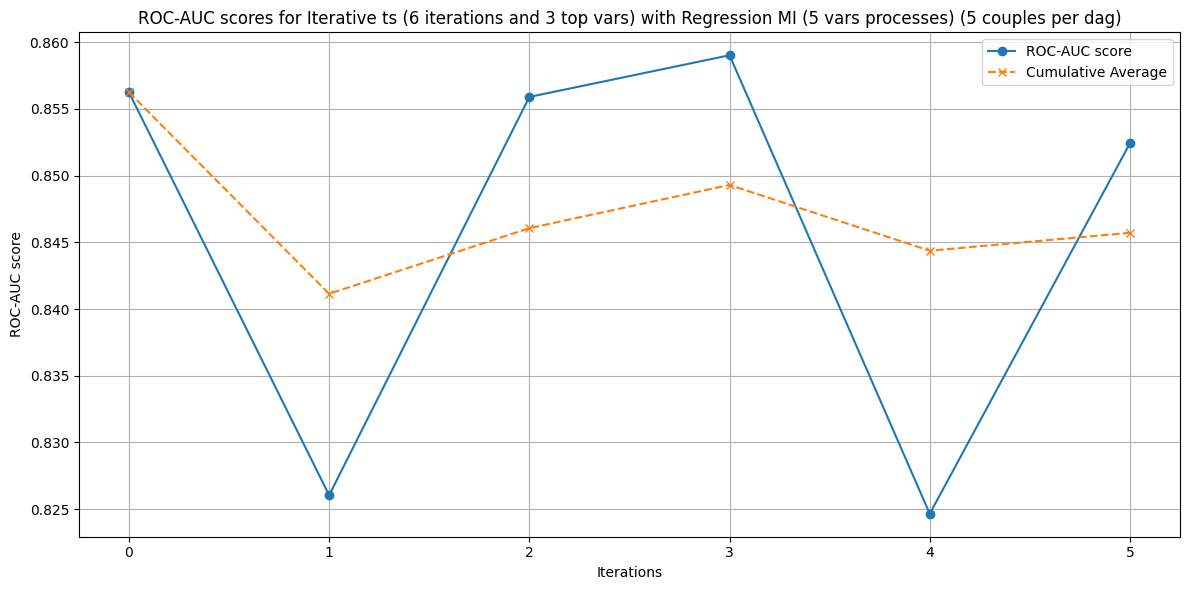


Resultant ROC-AUC scores:

   roc_score  iteration
0   0.856250          0
1   0.826042          1
2   0.855903          2
3   0.859028          3
4   0.824653          4
5   0.852431          5


°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
                          FINAL RESULTS                            
°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
The only improvement happened with these edges: 

   process_id  graph_id  edge_source  edge_dest  y_pred_proba
0           9        14           14          2          1.00
1          15        17            8          2          1.00
2          10         4            6          1          0.92
3           1         5            5          0          0.83
Try with a different strategy or change the parameters.


UnboundLocalError: local variable 'final_roc' referenced before assignment

In [5]:
Iter = IterativeTD2C(
    method = 'ts', 
    k = 1, 
    it = 7, 
    top_vars = 3, 
    treshold = False,
    treshold_value = 0.9, 
    adaptive = True,
    adaptive_mode = 'Balancing2',
    arbitrary = False,
    arbitrary_mode = 'Increasing',
    performative = False,
    performative_mode = 'Tail',
    size_causal_df = 3,
    data_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/', 
    descr_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/try_complete_function/', 
    results_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/try_complete_function/',
    COUPLES_TO_CONSIDER_PER_DAG = 5,
    MB_SIZE = 2,
    SEED = 42,
    maxlags = 5,
    max_neighborhood_size_filter = 2,

    N_JOBS = 40,
    noise_std_filter = 0.01
)

Iter.main()
